In [1]:
import pandas as pd


In [2]:
blacklist = pd.read_csv("phishing_database.csv")
whitelist = 'whitelist.txt'
urls = {}
#Assign 0 for non-malicious and 1 as malicious for supervised learning.
for url in blacklist['url']:
  urls[url] = 1
    
with open(whitelist, 'r') as f:
  lines = f.read().splitlines()
  for url in lines:
    urls[url] = 0

print(urls["google.com"])

0


In [3]:
from __future__ import print_function
import keras
from keras.preprocessing.text import Tokenizer
from keras.models import load_model
from keras.models import Sequential
from keras.layers import LSTM, GRU, Embedding, Dense, Flatten, Bidirectional
from keras.layers.core import Dense, Dropout, Activation
import numpy as np

In [4]:
samples = []
labels = []
for k, v in urls.items():
    samples.append(k)
    labels.append(v)
    #print(k, v)
    
print(labels.count(1))
print(labels.count(0))


29769
38228


In [5]:
max_chars = 20000
maxlen = 128

In [6]:
tokenizer = Tokenizer(num_words=max_chars, char_level=True)
tokenizer.fit_on_texts(samples)
sequences = tokenizer.texts_to_sequences(samples)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 69 unique tokens.


In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (67997, 128)
Shape of label tensor: (67997,)


In [8]:
training_samples = int(len(samples) * 0.80)
validation_samples = int(len(labels) * 0.10)
test_samples = int(len(labels) * 0.10)
print(training_samples, validation_samples, test_samples)

54397 6799 6799


In [9]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [10]:
x = data[:training_samples]
y = labels[:training_samples]
x_test = data[training_samples: training_samples + validation_samples]
y_test = labels[training_samples: training_samples + validation_samples]

In [11]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
    filepath='lstmchar256256128test.h5',
    monitor='val_loss',
    save_best_only=True
    ),
    keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=0,
    patience=2, 
    mode='auto',
    baseline=None,
    )
]

In [12]:
from keras.layers import TimeDistributed,Convolution2D, MaxPooling2D
num_chars = len(tokenizer.word_index)+1

embedding_vector_length = 128
# Create model for training.
model = Sequential()
  
model.add(TimeDistributed(Convolution2D(32, (7,7), strides=(2, 2),
      padding='same', activation='relu', input_shape=(num_chars, embedding_vector_length,maxlen))))
model.add(TimeDistributed(Convolution2D(32, (3,3),
      kernel_initializer="he_normal", activation='relu')))

model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Convolution2D(64, (3,3),
      padding='same', activation='relu')))
model.add(TimeDistributed(Convolution2D(64, (3,3),
      padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Convolution2D(128, (3,3),
      padding='same', activation='relu')))
model.add(TimeDistributed(Convolution2D(128, (3,3),
      padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Convolution2D(256, (3,3),
      padding='same', activation='relu')))
model.add(TimeDistributed(Convolution2D(256, (3,3),
      padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(Dropout(0.7))
model.add(LSTM(512, return_sequences=False, dropout=0.5))
model.add(Dense(1, activation='softmax'))


In [13]:
num_chars = len(tokenizer.word_index)+1

embedding_vector_length = 128

# Create model for training.
model1 = Sequential()
model1.add(Embedding(num_chars, embedding_vector_length, input_length=maxlen))
#model1.add((LSTM(256, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
model1.add(LSTM(256, dropout=0.3,  return_sequences=True))
model1.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3))
model1.add(Dense(1, activation='sigmoid'))

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 128)          8960      
                                                                 
 lstm_1 (LSTM)               (None, 128, 256)          394240    
                                                                 
 lstm_2 (LSTM)               (None, 128)               197120    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 600,449
Trainable params: 600,449
Non-trainable params: 0
_________________________________________________________________


In [14]:
num_chars = len(tokenizer.word_index)+1

embedding_vector_length = 128

# Create model for training.
model1 = Sequential()
model1.add(Embedding(num_chars, embedding_vector_length, input_length=maxlen))
model1.add(Bidirectional(LSTM(256, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
model1.add(Bidirectional(LSTM(256, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
model1.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3)))
model1.add(Dense(1, activation='sigmoid'))

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 128, 128)          8960      
                                                                 
 bidirectional (Bidirectiona  (None, 128, 512)         788480    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128, 512)         1574912   
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              656384    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                      

In [15]:
model1.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

In [18]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 128, 128)          8960      
                                                                 
 bidirectional (Bidirectiona  (None, 128, 512)         788480    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128, 512)         1574912   
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              656384    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                      

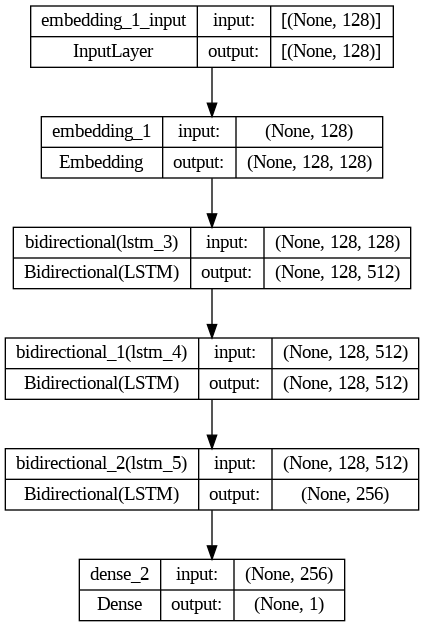

In [19]:
from keras.utils.vis_utils import plot_model

# plot the model and save it as an image
plot_model(model1, to_file='model.png', show_shapes=True)

In [ ]:
# Train.
history = model1.fit(x, y,
        epochs=3,
        batch_size=100,
        #callbacks=callbacks_list,
        validation_split=0.20,
        shuffle=True
        )

Epoch 1/3
436/436 [==============================] - 1431s 3s/step - loss: 0.3462 - accuracy: 0.8550 - val_loss: 0.4692 - val_accuracy: 0.7910
Epoch 2/3
436/436 [==============================] - 1410s 3s/step - loss: 0.3024 - accuracy: 0.8680 - val_loss: 0.1647 - val_accuracy: 0.9373
Epoch 3/3
321/436 [=====================>........] - ETA: 6:04 - loss: 0.1368 - accuracy: 0.9520

In [ ]:
score, acc = model1.evaluate(x_test, y_test, verbose=1, batch_size=1024)

print("Model Accuracy: {:0.2f}%".format(acc * 100))

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Predict the test data using the trained model
y_pred = model1.predict(x_test)
y_pred_classes = np.round(y_pred)

In [ ]:

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Classification report
cr = classification_report(y_test, y_pred_classes)
print("Classification Report:")
print(cr)

In [ ]:
# Plot accuracy and loss during training
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc

# compute ROC curve and AUC for positive class
fpr, tpr, thresholds = roc_curve(y_test, y_pred_classes)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
tick_marks = np.arange(len(set(labels)))
plt.xticks(tick_marks, ['Non-malicious', 'Malicious'], rotation=45)
plt.yticks(tick_marks, ['Non-malicious', 'Malicious'])
plt.tight_layout()
plt.show()
